<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Carolina Barba Anaya y Jose Antonio Contreras Peña.

**Fecha:** 23 de Noviembre del 2021.

**Expediente** : if720071 y if721860
    
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/Carolina1002/ProyectoConjunto_CBarba_JAContreras.git

# Tarea 8: 

Replicar el procedimiento anterior para valoración de opciones 'call', pero en este caso para opciones tipo 'put' y además deben de comparar con los resultados teoricos del método de valuación de Black-Scholes (ecuación del principio de clase)

### CODIGO CAROLINA

In [1]:
#Librerias
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as st
import yfinance as yf
from datetime import date
import seaborn as sns; sns.set();
%matplotlib inline
#algunas opciones para Pandas
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
def get_adj_closes(tickers, start_date=None, end_date=None):
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    closes = closes['Adj Close']
    closes.sort_index(inplace=True)
    return closes

def daily_ret(closes):
    return np.log(closes/closes.shift(1)).iloc[1:]

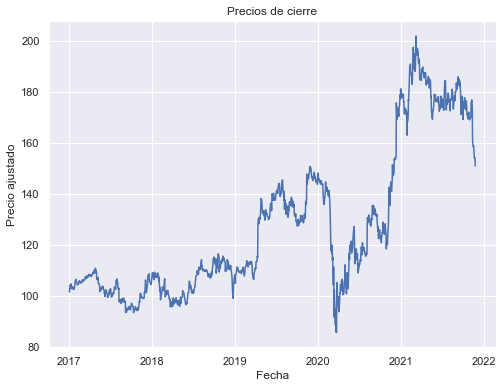

In [3]:
#Precios de cierre DISNEY
ticker = ["DIS"]
start_date = "2017-01-01"
closes_dis = get_adj_closes(ticker, start_date)
plt.figure(figsize = [8, 6])
plt.plot(closes_dis)
plt.title("Precios de cierre")
plt.xlabel("Fecha")
plt.ylabel("Precio ajustado")
plt.show()


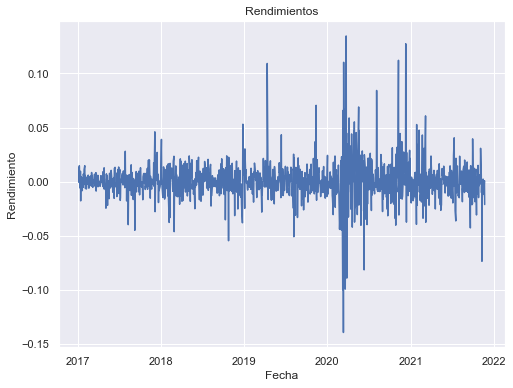

In [4]:
# Rendimientos
rend = daily_ret(closes_dis)
plt.figure(figsize = [8, 6])
plt.plot(rend)
plt.title("Rendimientos")
plt.xlabel("Fecha")
plt.ylabel("Rendimiento")
plt.show()

In [5]:
import requests

def obtener_datos_opciones(symbol):
    headers = headers = {
            'Connection': 'keep-alive',
            'Expires': str(-1),
            'Upgrade-Insecure-Requests': str(1),
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
    }
    url = f'https://query1.finance.yahoo.com/v7/finance/options/{symbol}'
    r = requests.get(url, headers=headers)
    dates = r.json()['optionChain']['result'][0]['expirationDates']
    
    calls = []
    puts = []
    
    for d in dates:
        res = requests.get(url + f'?date={d}', headers=headers)
        calls += res.json()['optionChain']['result'][0]['options'][0]['calls']
        puts += res.json()['optionChain']['result'][0]['options'][0]['puts']

    for c in calls:
        c['type'] = 'call'
        c['lastTradeDate'] = pd.to_datetime(c['lastTradeDate']*1000000000)
        c['expiration'] = pd.to_datetime(c['expiration']*1000000000)
    for p in puts:
        p['type'] = 'put'
        p['lastTradeDate'] = pd.to_datetime(p['lastTradeDate']*1000000000)
        p['expiration'] = pd.to_datetime(p['expiration']*1000000000)
    
    return pd.DataFrame(calls + puts)

In [6]:
opciones_dis = obtener_datos_opciones('DIS')

In [7]:
opciones_dis

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
0,DIS211126C00105000,105.0,USD,...,2.041e+00,True,call
1,DIS211126C00110000,110.0,USD,...,1.838e+00,True,call
2,DIS211126C00115000,115.0,USD,...,1.669e+00,True,call
3,DIS211126C00120000,120.0,USD,...,1.440e+00,True,call
4,DIS211126C00125000,125.0,USD,...,1.220e+00,True,call
...,...,...,...,...,...,...,...
920,DIS240119P00220000,220.0,USD,...,2.841e-01,True,put
921,DIS240119P00230000,230.0,USD,...,1.000e-05,True,put
922,DIS240119P00240000,240.0,USD,...,2.875e-01,True,put
923,DIS240119P00260000,260.0,USD,...,2.897e-01,True,put


In [8]:
K = 290 # Strike price
indice_opt = opciones_dis.loc[(opciones_dis.type == "put") & (opciones_dis.strike == K) & (opciones_dis.expiration == "2023-01-20")]
indice_opt

,contractSymbol,strike,currency,...,impliedVolatility,inTheMoney,type
894,DIS230120P00290000,290.0,USD,...,0.275,True,put


In [9]:
i_opt = indice_opt.index
opcion_valuar = opciones_dis.loc[i_opt[0]]
opcion_valuar

contractSymbol        DIS230120P00290000
strike                             290.0
currency                             USD
lastPrice                         137.12
change                               0.0
                            ...         
expiration           2023-01-20 00:00:00
lastTradeDate        2021-11-19 18:42:52
impliedVolatility                  0.275
inTheMoney                          True
type                                 put
Name: 894, Length: 16, dtype: object

In [10]:
mu = rend.mean()[0]
sigma = rend.std()[0]
r = 0.0018 / 360 # tasa diaria libre de riesgo
today = pd.Timestamp(datetime.date.today())
expiry = opcion_valuar.expiration
T = expiry - today

In [11]:
print("Media de los rendimientos: " + str(mu))
print("Desviación estándar de los rendimientos" + str(sigma))
print("La tasa libre de riesgo es " + str(r))
print("El tiempo que le resta a la opción " + str(T))

Media de los rendimientos: 0.00032153027736371017
Desviación estándar de los rendimientos0.01821500133888873
La tasa libre de riesgo es 4.9999999999999996e-06
El tiempo que le resta a la opción 423 days 00:00:00


In [12]:
K = 290
dates = pd.date_range(start = today, end = expiry, freq = "B") 
ndays = len(dates) 
nscen = 100000 
S0 = closes_dis.iloc[-1, 0] 
sim_ret = pd.DataFrame(sigma * np.random.randn(ndays, nscen) + r, index = dates) 
sim_closes = S0 * np.exp(sim_ret.cumsum()) 
strike = pd.DataFrame(K * np.ones([ndays, nscen]), index = dates) 
put = pd.DataFrame({"Prima": np.exp(-r * ndays)  * np.fmax(strike - sim_closes, 0).mean(axis = 1)}) 

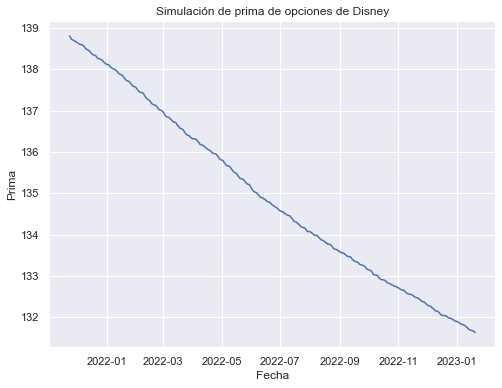

In [13]:
plt.figure(figsize = [8, 6])
plt.plot(put)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show()

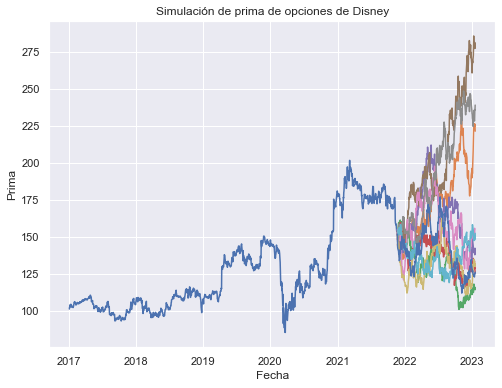

In [14]:
plt.figure(figsize = [8, 6]) # simulación de montecarlo
sim_normal = pd.concat([closes_dis, sim_closes[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])
plt.plot(sim_normal)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

In [15]:
put.iloc[-1] # valuación de la opción

Prima    131.631
Name: 2023-01-20 00:00:00, dtype: float64

In [16]:
confianza = 0.95 # intervalo de confianza
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc = mean_est, scale = sigma_est)
print("Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza", i2)

Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza (131.31037234837046, 131.9524437551049)


In [17]:
# Usando muestreo estratificado -> # estratros = nscen
U = (np.random.rand(ndays, nscen) + np.arange(0, nscen)) / nscen
Z = st.norm.ppf(U)
sim_ret2 = pd.DataFrame(sigma * Z + r, index = dates)
sim_closes2 = S0 * np.exp(sim_ret2.cumsum())
strike = pd.DataFrame(K * np.ones([ndays, nscen]), index = dates) # función de pago
put = pd.DataFrame({"Prima": np.exp(-r * ndays) * np.fmax(strike - sim_closes2, 0).T.mean()}, index = dates)

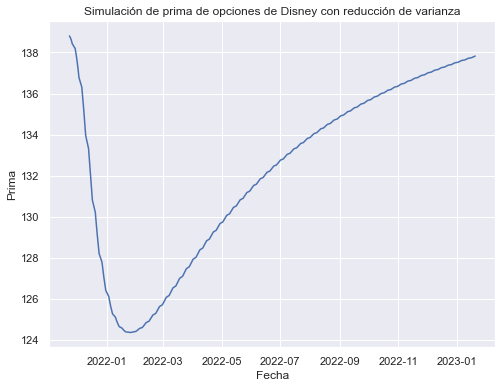

In [18]:
plt.figure(figsize = [8, 6])
plt.plot(put)
plt.title("Simulación de prima de opciones de Disney con reducción de varianza")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show()


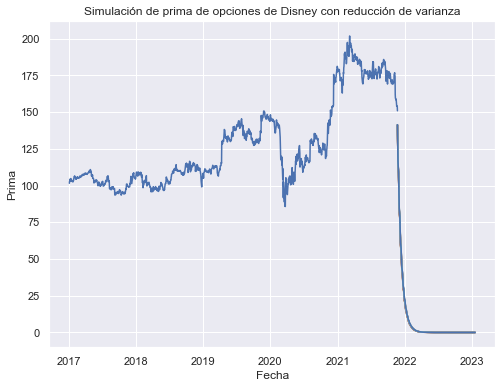

In [19]:
plt.figure(figsize = [8, 6]) # simulación de montecarlo
sim_reduc = pd.concat([closes_dis, sim_closes2[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]])
plt.plot(sim_reduc)
plt.title("Simulación de prima de opciones de Disney con reducción de varianza")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

In [20]:
put.iloc[-1] # valuación de la opción

Prima    137.826
Name: 2023-01-20 00:00:00, dtype: float64

In [21]:
sigma_est = sim_closes2.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc = mean_est)
print("Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza", i2)

Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza (135.86651428107902, 139.78644225015913)


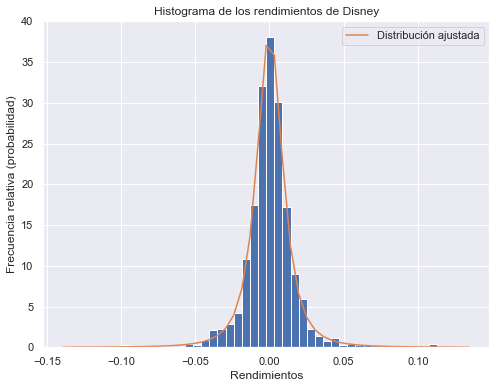

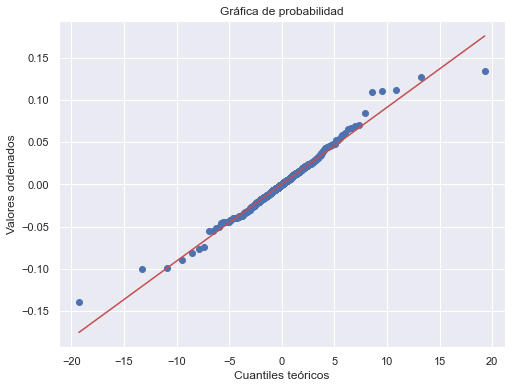

In [22]:
ren = daily_ret(closes_dis) # rendimientos
plt.figure(figsize = [8, 6])
y, x, _ = plt.hist(ren["DIS"], bins = 50, density = True) 
dist = "t" 
params = getattr(st, dist).fit(ren.values) 
curve_fit = getattr(st, dist).pdf(x, *params) 
plt.plot(x, curve_fit, label = "Distribución ajustada")
plt.title("Histograma de los rendimientos de Disney")
plt.xlabel("Rendimientos")
plt.ylabel("Frecuencia relativa (probabilidad)")
plt.legend()
plt.show()
plt.figure(figsize = [8, 6])
st.probplot(ren["DIS"], sparams = params[:-2], dist = dist, plot = plt); # gráfica Q-Q
plt.title("Gráfica de probabilidad")
plt.xlabel("Cuantiles teóricos")
plt.ylabel("Valores ordenados")
plt.show()


In [23]:
K = 290
nscen = 100000
ndays = len(dates)
freq, values = np.histogram(rend + r - mu, bins = 2000) # histograma tomando la tasa libre de riesgo
prob = freq / np.sum(freq)
ret = np.random.choice(values[1:], ndays * nscen, p = prob) # simulación de los rendimientos
sim_ret_hist = pd.DataFrame(ret.reshape((ndays, nscen)), index = dates) # simulación de precios
sim_closes_hist = (closes_dis.iloc[-1, 0]) * np.exp(sim_ret_hist.cumsum())
strike = pd.DataFrame(K * np.ones(ndays * nscen).reshape((ndays, nscen)), index = dates)
put_hist = pd.DataFrame({"Prima": np.exp(-r * ndays) * np.fmax(strike - sim_closes_hist, 0).T.mean()}, index = dates)

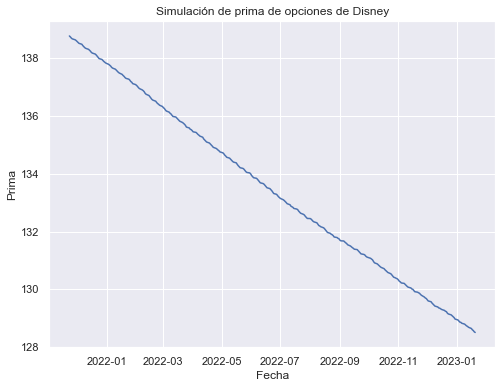

In [24]:
plt.figure(figsize = [8, 6])
plt.plot(put_hist)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

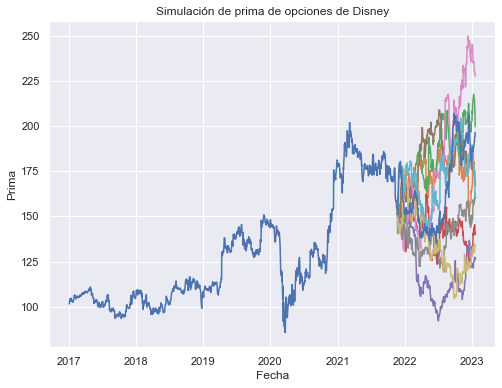

In [25]:
plt.figure(figsize = [8, 6]) # simulación de montecarlo
sim_hist = pd.concat([closes_dis, sim_closes_hist[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]])
plt.plot(sim_hist)
plt.title("Simulación de prima de opciones de Disney")
plt.xlabel("Fecha")
plt.ylabel("Prima")
plt.show();

In [26]:
put_hist.iloc[-1] # valuación de la opción

Prima    128.505
Name: 2023-01-20 00:00:00, dtype: float64

In [27]:
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
i2 = st.norm.interval(confianza, loc = mean_est, scale = sigma_est)
print("Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza", i2)

Con un 95% de confianza, el valor de la opción de Disney está dentro del intervalo de confianza (128.17720046229928, 128.8325468571164)


#### Comparación metodo Black-Scholes

El valor actual de la opción es:
$$ \text{Valor actual de la opción put} = V(S_0, T) = K e^{-r \cdot T} \cdot N(-d_2) - S_0 \cdot N(-d_1) $$

Para calcular $d_1$ y $d_2$:
$$ d_1 = \frac{\ln{\frac{S_0}{K}} + (r + \frac{\sigma^2}{2}) \cdot T}{\sigma \sqrt{T}} = \frac{\ln{\frac{151.61}{290}} + (\frac{0.0018}{360} + \frac{0.01821^2}{2}) \cdot 423}{0.01821 \sqrt{423}} = -1.5388$$
$$ d_2 = \frac{\ln{\frac{S_0}{K}} + (r - \frac{\sigma^2}{2}) \cdot T}{\sigma \sqrt{T}} = \frac{\ln{\frac{151.61}{290}} + (\frac{0.0018}{360} - \frac{0.01821^2}{2}) \cdot 423}{0.01821 \sqrt{423}} = -1.9133$$

Entonces,
$$N(-d_1) = N(1.5388)= 0.9370$$ y $$N(-d_2) = N(1.9133) = 0.9719$$

Así, sustituyendo en la ecuación presentada anteriormente,
$$ \text{Valor actual de la opción} = V(151.61, 423) = 290 e^{-\frac{0.0018}{360} \cdot 423} \cdot 0.9719 - 151.61 \cdot 0.9370 = 139.1969 $$


Podemos observar que el valor en el metodo de Black-Scholes es mayor que las simulaciones anteriores 

### CODIGO ANTONIO